In [6]:
#Importing modules and libraries

In [7]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [9]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
         "PlantVillage",
          shuffle=True,
          image_size=(IMAGE_SIZE,IMAGE_SIZE),
          batch_size= BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [10]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
68*32

2176

In [13]:
#Data visulaization

In [14]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[168. 165. 176.]
  [122. 119. 130.]
  [165. 162. 173.]
  ...
  [117. 115. 120.]
  [144. 142. 147.]
  [134. 132. 137.]]

 [[129. 126. 137.]
  [143. 140. 151.]
  [196. 193. 204.]
  ...
  [129. 127. 132.]
  [172. 170. 175.]
  [177. 175. 180.]]

 [[182. 179. 190.]
  [146. 143. 154.]
  [124. 121. 132.]
  ...
  [171. 168. 175.]
  [173. 170. 177.]
  [127. 124. 131.]]

 ...

 [[195. 193. 204.]
  [195. 193. 204.]
  [195. 193. 204.]
  ...
  [176. 174. 187.]
  [179. 177. 190.]
  [186. 184. 197.]]

 [[188. 186. 197.]
  [192. 190. 201.]
  [196. 194. 205.]
  ...
  [175. 173. 186.]
  [176. 174. 187.]
  [181. 179. 192.]]

 [[177. 175. 186.]
  [186. 184. 195.]
  [195. 193. 204.]
  ...
  [174. 172. 185.]
  [173. 171. 184.]
  [177. 175. 188.]]], shape=(256, 256, 3), dtype=float32)


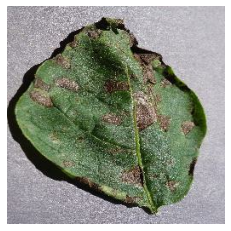

In [15]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")

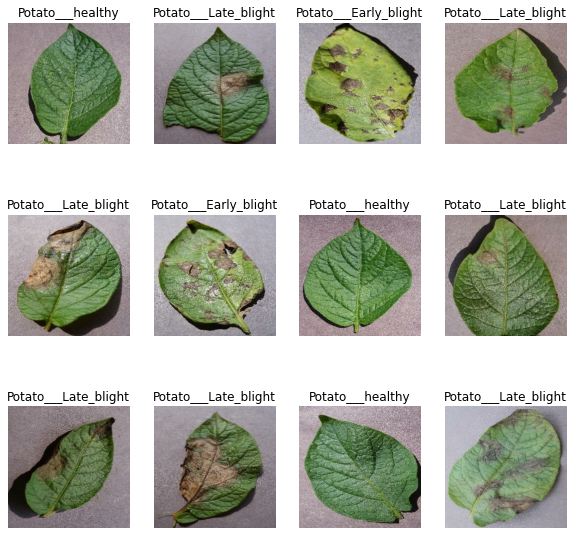

In [16]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [17]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [18]:
train_ds=dataset.take(54)
len(train_ds)

54

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [20]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [21]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [22]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [23]:
#Splitting Dataset into train, test and validation

In [24]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [26]:
len(train_ds)

54

In [27]:
len(val_ds)

6

In [28]:
len(test_ds)

8

In [29]:
#Caching and making full use of CPU and GPU

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
#Resizing every image to 256x256

In [32]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [33]:
#Data augmentation: Making tarining system robust by training all rotated, etc images

In [34]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [35]:
#Build CNN Model

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [38]:
#Compile model for accuracy and losses

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
history= model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 101s 2s/step - loss: 0.9201 - accuracy: 0.4774 - val_loss: 0.8558 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 92s 2s/step - loss: 0.7572 - accuracy: 0.6088 - val_loss: 0.5024 - val_accuracy: 0.7552
Epoch 3/50
54/54 [==============================] - 108s 2s/step - loss: 0.4145 - accuracy: 0.8223 - val_loss: 0.3587 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 131s 2s/step - loss: 0.3124 - accuracy: 0.8825 - val_loss: 0.3527 - val_accuracy: 0.8385
Epoch 5/50
54/54 [==============================] - 117s 2s/step - loss: 0.2630 - accuracy: 0.8970 - val_loss: 0.2348 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 99s 2s/step - loss: 0.2084 - accuracy: 0.9184 - val_loss: 0.1579 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 94s 2s/step - loss: 0.1904 - accuracy: 0.9236 - val_loss: 0.1152 - val_accuracy: 0.9531
Epoch 8/50
54/54

In [41]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 5s 404ms/step - loss: 3.2516e-04 - accuracy: 1.0000


In [42]:
scores

[0.00032516231294721365, 1.0]

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

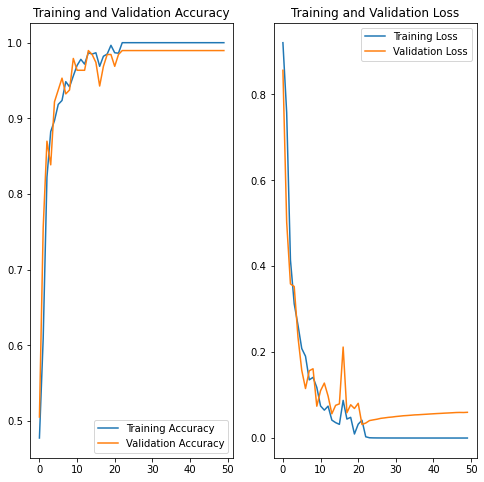

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
#Run model on test images

first image to predict
actual label: Potato___healthy
predicted label: Potato___healthy


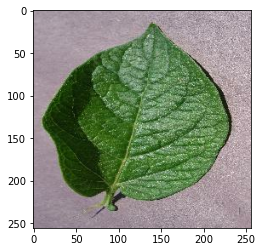

In [48]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [50]:
#Run model on few images

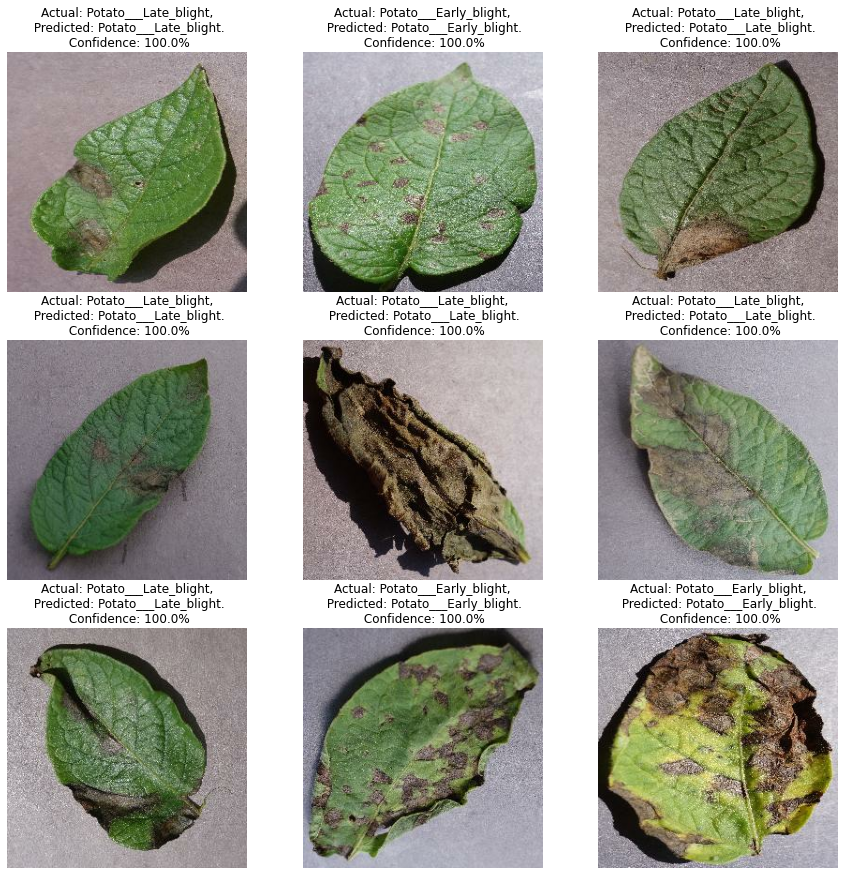

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [52]:
#saving the model

In [54]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../models'

In [55]:
model.save("../potatoes.h5")

In [56]:
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets
